In [1]:
# https://github.com/srikeshnagoji/unet3p-attn/tree/unet-3p-with-attention-rearch-v2

In [2]:
# # DO 

# !pip uninstall Albumentations
# !pip install Albumentations==0.5.2

In [3]:
# Dice link: https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388

In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")
%matplotlib inline


In [2]:
from prepareData.prepareData import get_dataset_dataframe
from util.helper import pos_neg_diagnosis, show_aug, train_model, plot_model_history, viz_pred_output, load_ckp
from prepareData import augmentData, customDatasetObject
from model.unet3p_attention import UNet_3Plus_attn
from model.unet3p import UNet3Plus
from model.unet_attention import AttentionUNet
from metrics.diceMetrics import dice_coef_metric, DiceLoss, compute_iou


In [3]:
BASE_PATH= "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m"

In [4]:
BASE_LEN = len(BASE_PATH) + len("/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")
END_LEN = len(".tif") # image
END_MASK_LEN = len("_mask.tif") # mask

IMG_SIZE = 512

# Prepare data

In [5]:
df = get_dataset_dataframe(BASE_PATH)

[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/data.csv
[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/README.md


In [6]:
df

,dir_name,image_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
...,...,...
7853,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7854,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7855,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7856,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [7]:
# for i in df[df.dir_name=="TCGA_CS_6667_20011105"].image_path[:100]:
#     print(i)

In [8]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [9]:
df_imgs.iloc[0,1][BASE_LEN: -END_LEN]

'9'

In [10]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int((x[BASE_LEN: -END_LEN])))
masks = sorted(df_masks["image_path"].values, key=lambda x: int((x[BASE_LEN: -END_MASK_LEN])))

In [11]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_7.tif*
 Belongs to the mask */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_7_mask.tif*


In [12]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [13]:
dff.iloc[0,1]

'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1.tif'

In [14]:
dff.iloc[0,2]


'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1_mask.tif'

In [15]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0


In [16]:
dff.shape


(3929, 4)

In [17]:
dff.diagnosis.value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [18]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

from sklearn.model_selection import train_test_split

In [20]:
import platform
import sklearn as sk
import sys
has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.0.1-arm64-arm-64bit
PyTorch Version: 1.12.1

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


# Split Data and DataLoaders

In [21]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [22]:
train_dataset = customDatasetObject.BrainMRIDataset(train_df, transform=augmentData.transform)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = customDatasetObject.BrainMRIDataset(val_df, transform=augmentData.transform)
val_dataloader = DataLoader(val_dataset, batch_size=10,  shuffle=True)

test_dataset = customDatasetObject.BrainMRIDataset(test_df, transform=augmentData.transform)
test_dataloader = DataLoader(test_dataset, batch_size=10,shuffle=True)

In [23]:
len(train_dataset)

3111

In [24]:
len(val_dataset)

393

In [25]:
len(test_dataset)

425

torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


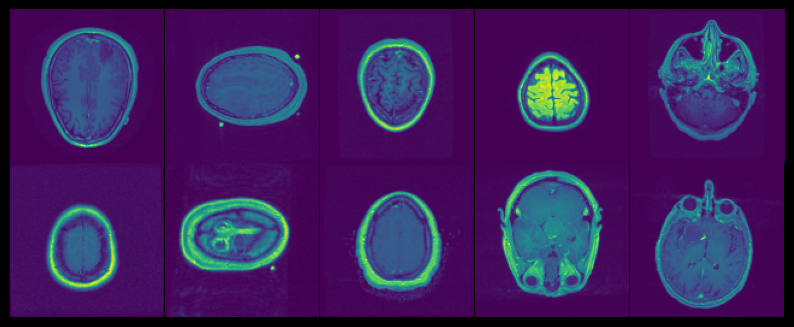

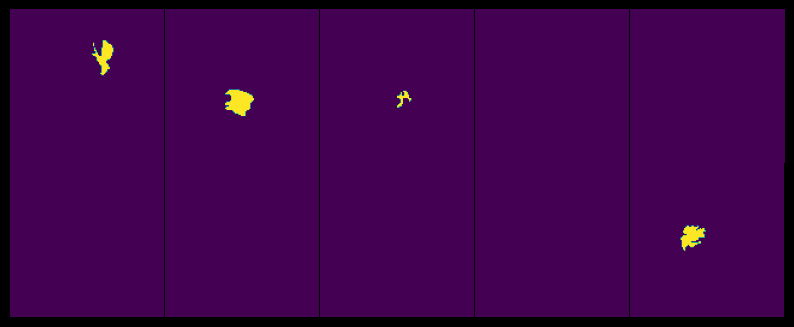

In [26]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

In [27]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

In [28]:
# sanity check
DiceLoss()(F.sigmoid(torch.tensor([0.7, 1., 1.])), 
              torch.tensor([1.,1.,1.]))

/Users/srikeshnagoji/miniforge3/envs/capstone/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1419)

# U-NET 3+ with attention

In [28]:

unet3p_attn = UNet_3Plus_attn(n_classes=1).to(device)

In [29]:
# Training

In [30]:
# PATH = "model_unet_3p_attn.pt"



Adamax is an optimization algorithm used in deep learning and is a variant of the popular Adam (Adaptive Moment Estimation) algorithm.

Adamax is similar to Adam in that it calculates adaptive learning rates for each weight in the model and uses the moving average of the squared gradients to scale the learning rates. However, instead of using the L2-norm of the gradients to scale the learning rates as in Adam, Adamax uses the infinity-norm of the gradients.

Adamax uses the following update rule:

m_t = beta1 * m_{t-1} + (1 - beta1) * g_t
u_t = max(beta2 * u_{t-1}, abs(g_t))
w_t = w_{t-1} - learning_rate * m_t / (u_t + epsilon)

where m_t is the moving average of the gradients, u_t is the moving average of the infinity-norm of the gradients, g_t is the gradient of the loss with respect to the parameters at time step t, beta1 and beta2 are hyperparameters, epsilon is a small constant to avoid division by zero, and learning_rate is the learning rate.

Adamax is known to be well-suited for dealing with sparse gradients and to work well in practice for deep learning models.

In [31]:
opt_unet_3p_attn = torch.optim.Adamax(unet3p_attn.parameters(), lr=1e-4)


In [35]:
# ckp_path = "path/to/checkpoint/checkpoint.pt"


In [36]:
# %%time
num_ep = 120
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_3p_attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p_attn, False, num_ep, device=device)

total params of UNet_3p_attn model: 28043917
trainable params of UNet_3p_attn model: 28043917
[INFO] Model is initializing... UNet_3p_attn


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.5179927047246542 
Mean DICE on train: 0.516112053841808 
Mean DICE on validation: 0.6691577371773514


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.34918265560498607 
Mean DICE on train: 0.6652262172026605 
Mean DICE on validation: 0.6937260835250404


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.32096318422983855 
Mean DICE on train: 0.6882418950885608 
Mean DICE on validation: 0.7364696692516697


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.2933287114287034 
Mean DICE on train: 0.7117797858987103 
Mean DICE on validation: 0.7590978504427311


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.28101177246142656 
Mean DICE on train: 0.7282154894576036 
Mean DICE on validation: 0.7192910593593306


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.273352759770858 
Mean DICE on train: 0.7364564404201915 
Mean DICE on validation: 0.7436062271827867


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.24834934507425016 
Mean DICE on train: 0.7557452061238883 
Mean DICE on validation: 0.7056672012210436


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.24042137884176695 
Mean DICE on train: 0.7651772786190364 
Mean DICE on validation: 0.7884184875686869


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.23798752232239798 
Mean DICE on train: 0.7658413344279668 
Mean DICE on validation: 0.7178318580043354


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.2301366375042842 
Mean DICE on train: 0.7739657699568812 
Mean DICE on validation: 0.7631438727104527


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.22245542819683367 
Mean DICE on train: 0.7897812928647778 
Mean DICE on validation: 0.7767941719845952


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.21114453042928988 
Mean DICE on train: 0.7931587632068915 
Mean DICE on validation: 0.7878624865992019


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.22401396414408317 
Mean DICE on train: 0.7787505077476785 
Mean DICE on validation: 0.8097178009255946


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.2111211610146058 
Mean DICE on train: 0.7931068179382025 
Mean DICE on validation: 0.8131883327422672


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.20418960677507597 
Mean DICE on train: 0.7984342163505966 
Mean DICE on validation: 0.7572828800453991


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.20632836165336463 
Mean DICE on train: 0.8045222193231851 
Mean DICE on validation: 0.8112561297621145


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.19694792326444235 
Mean DICE on train: 0.8073212116468553 
Mean DICE on validation: 0.8056322056495258


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.19993502933245438 
Mean DICE on train: 0.8067814403950978 
Mean DICE on validation: 0.8135896064874222


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.20849363410320038 
Mean DICE on train: 0.7934047950199058 
Mean DICE on validation: 0.8121621479446554


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.1970181195781781 
Mean DICE on train: 0.8069708675946142 
Mean DICE on validation: 0.861698339275963


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.1830882815978466 
Mean DICE on train: 0.8223113272537651 
Mean DICE on validation: 0.831540299363345


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.1865446932422809 
Mean DICE on train: 0.8228047281890832 
Mean DICE on validation: 0.8523270737536693


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.19139181077480316 
Mean DICE on train: 0.8159284879587023 
Mean DICE on validation: 0.7856764151895798


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.17667730840352866 
Mean DICE on train: 0.8261999500440665 
Mean DICE on validation: 0.8153766470583599


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.18423920659682688 
Mean DICE on train: 0.8186306414785296 
Mean DICE on validation: 0.8289071050920384


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.18211844181403136 
Mean DICE on train: 0.8259154166051628 
Mean DICE on validation: 0.8036052640342674


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.19267622094887954 
Mean DICE on train: 0.8181687827955157 
Mean DICE on validation: 0.8264374876589458


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.17242763057733193 
Mean DICE on train: 0.8320733174988718 
Mean DICE on validation: 0.8123947525527728


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.18161128843441987 
Mean DICE on train: 0.8231491349441676 
Mean DICE on validation: 0.7887059508548196


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.17930823545425367 
Mean DICE on train: 0.823283906910448 
Mean DICE on validation: 0.7915263901599704


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.17774836222330728 
Mean DICE on train: 0.8251259282658437 
Mean DICE on validation: 0.8405823569750022


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.17630063131069526 
Mean DICE on train: 0.8268323533030337 
Mean DICE on validation: 0.786937020119196


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.1751438490091226 
Mean DICE on train: 0.8285501021240501 
Mean DICE on validation: 0.7868880346869049


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.16973378413762802 
Mean DICE on train: 0.8320700894116602 
Mean DICE on validation: 0.8190642487698472


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.1720087182445404 
Mean DICE on train: 0.8310307900642356 
Mean DICE on validation: 0.8240162750067993


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.1637235912374961 
Mean DICE on train: 0.8373106948263376 
Mean DICE on validation: 0.8352331230259771


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.16938231770808881 
Mean DICE on train: 0.8332828239708382 
Mean DICE on validation: 0.8031577665085267


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.1712855177047925 
Mean DICE on train: 0.8321615924920087 
Mean DICE on validation: 0.8383019992426509


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.16687107525574854 
Mean DICE on train: 0.8362785977817162 
Mean DICE on validation: 0.8361079581376197


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.17348230725679642 
Mean DICE on train: 0.8297332533823402 
Mean DICE on validation: 0.8124029451536164


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.16258907814820608 
Mean DICE on train: 0.8406465259307608 
Mean DICE on validation: 0.8363286502746339


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.16846905094690812 
Mean DICE on train: 0.8339212426725083 
Mean DICE on validation: 0.8347355392564273


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.17345124597732836 
Mean DICE on train: 0.8274633243326559 
Mean DICE on validation: 0.8352742652942785


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.16134560471161818 
Mean DICE on train: 0.8404044640694861 
Mean DICE on validation: 0.8540043861329397


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.16156855607644105 
Mean DICE on train: 0.8407618227150178 
Mean DICE on validation: 0.8366061345937266


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.16619484948042113 
Mean DICE on train: 0.8343026349080407 
Mean DICE on validation: 0.8253185039387475


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.15682414498848793 
Mean DICE on train: 0.8458995632850382 
Mean DICE on validation: 0.8510867085458218


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.14735811948776245 
Mean DICE on train: 0.8567424322161407 
Mean DICE on validation: 0.8047025356921803


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.14983209757468638 
Mean DICE on train: 0.8522782682655973 
Mean DICE on validation: 0.8458051980623901


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.1448314761122068 
Mean DICE on train: 0.8561836715717911 
Mean DICE on validation: 0.8588801523282603


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [50]
Mean loss on train: 0.1662807006102342 
Mean DICE on train: 0.8347627103823984 
Mean DICE on validation: 0.8184187492529212


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [51]
Mean loss on train: 0.1552594686165834 
Mean DICE on train: 0.8478804875595588 
Mean DICE on validation: 0.814179738677509


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [52]
Mean loss on train: 0.13462342207248396 
Mean DICE on train: 0.867564213210589 
Mean DICE on validation: 0.8621828192381412


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [53]
Mean loss on train: 0.14083396719816405 
Mean DICE on train: 0.863929655488189 
Mean DICE on validation: 0.8302203442932186


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [54]
Mean loss on train: 0.13903918442053673 
Mean DICE on train: 0.8628540996950493 
Mean DICE on validation: 0.8777488297066708


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [55]
Mean loss on train: 0.1359303035797217 
Mean DICE on train: 0.8655155625739019 
Mean DICE on validation: 0.8827853271600026


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [56]
Mean loss on train: 0.1514733055463204 
Mean DICE on train: 0.8497992641190987 
Mean DICE on validation: 0.84055773334735


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [57]
Mean loss on train: 0.13833116529843745 
Mean DICE on train: 0.8632618968406237 
Mean DICE on validation: 0.8327119932194432


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [58]
Mean loss on train: 0.15056449595170143 
Mean DICE on train: 0.8509429802555647 
Mean DICE on validation: 0.8453733192024822


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [59]
Mean loss on train: 0.13673633432541138 
Mean DICE on train: 0.864881501959215 
Mean DICE on validation: 0.8509737410309293


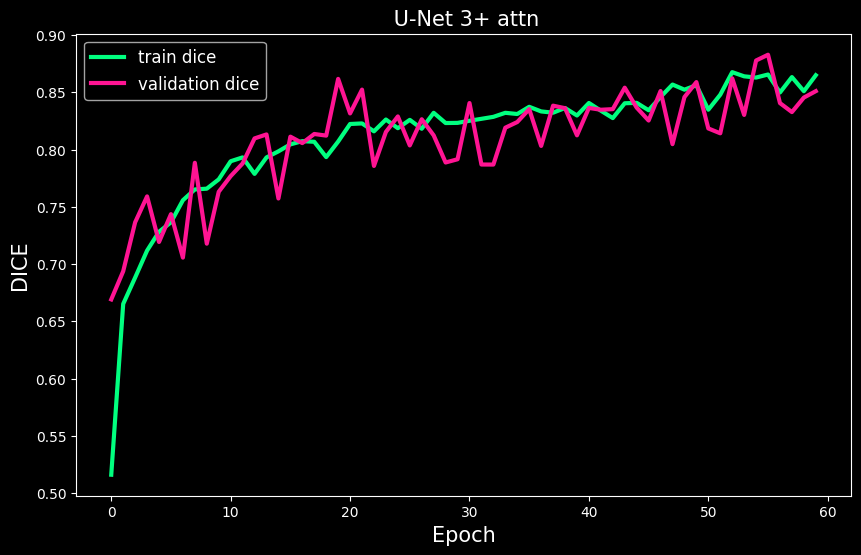

In [37]:
plot_model_history(" U-Net 3+ attn", aun_th, aun_vh, num_ep)

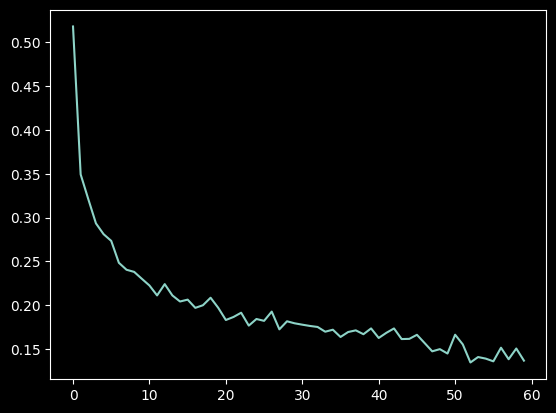

In [38]:
plt.plot(range(num_ep), aun_lh)

In [39]:
test_iou = compute_iou(unet3p_attn, test_dataloader, device)
print(f"""U-Net 3+ Attention\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

U-Net 3+ Attention
Mean IoU of the test images - 82.0%


In [40]:
aun_lh_prev, aun_th_prev, aun_vh_prev = aun_lh, aun_th, aun_vh

In [42]:
last_num_ep = num_ep

In [35]:
def save_metadata():
    #Saving initial history
    np.savetxt('metadata/UNet_3p_attn/aun_lh_prev.txt', aun_lh_prev)
    np.savetxt('metadata/UNet_3p_attn/aun_th_prev.txt', aun_th_prev)
    np.savetxt('metadata/UNet_3p_attn/aun_vh_prev.txt', aun_vh_prev)


In [96]:
save_metadata()

In [ ]:
# CONTINUE WHERE LEFT OFF / TRAIN MORE:

In [32]:
aun_lh_prev = np.loadtxt('metadata/UNet_3p_attn/aun_lh_prev.txt')
aun_th_prev = np.loadtxt('metadata/UNet_3p_attn/aun_th_prev.txt')
aun_vh_prev = np.loadtxt('metadata/UNet_3p_attn/aun_vh_prev.txt')
last_num_ep = len(aun_lh_prev)

In [33]:
for_x_more_epochs = 10

In [34]:
ckp_path = "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/v3_pytorch_refactored/checkpoints/UNet_3p_attn/checkpoint.pt"
aun_lh, aun_th, aun_vh = train_model("UNet_3p_attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p_attn, False, for_x_more_epochs, device=device, ckp_path=ckp_path )
aun_lh_prev = np.append(aun_lh_prev , aun_lh)
aun_th_prev = np.append(aun_th_prev , aun_th)
aun_vh_prev = np.append(aun_vh_prev , aun_vh)
last_num_ep = last_num_ep + for_x_more_epochs


total params of UNet_3p_attn model: 28043917
trainable params of UNet_3p_attn model: 28043917
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 89 number of epochs...
Train for 10 more epochs...
[INFO] Model is initializing... UNet_3p_attn


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [90]
Mean loss on train: 0.12144187837839127 
Mean DICE on train: 0.8798275401915376 
Mean DICE on validation: 0.882616573146877


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [91]
Mean loss on train: 0.1183055471151303 
Mean DICE on train: 0.8844929847321503 
Mean DICE on validation: 0.8808221327893008


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [92]
Mean loss on train: 0.12655945255970344 
Mean DICE on train: 0.875172328694253 
Mean DICE on validation: 0.8945850767791796


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [93]
Mean loss on train: 0.14142393320798874 
Mean DICE on train: 0.8596872224406087 
Mean DICE on validation: 0.8763639200911655


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [94]
Mean loss on train: 0.13047831715681615 
Mean DICE on train: 0.8729771667175564 
Mean DICE on validation: 0.8782881669695177


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [95]
Mean loss on train: 0.12917195031276116 
Mean DICE on train: 0.8714749781490051 
Mean DICE on validation: 0.8982769508753713


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [96]
Mean loss on train: 0.12653154058334154 
Mean DICE on train: 0.874629083838839 
Mean DICE on validation: 0.902780340801026


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [97]
Mean loss on train: 0.13421345807802984 
Mean DICE on train: 0.866939390712676 
Mean DICE on validation: 0.9190321571199106


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [98]
Mean loss on train: 0.12843520194292068 
Mean DICE on train: 0.8741374192580152 
Mean DICE on validation: 0.8938252313162289


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [99]
Mean loss on train: 0.11604429513980181 
Mean DICE on train: 0.8846156435960333 
Mean DICE on validation: 0.8825715602908301


NameError: name 'save_metadata' is not defined

In [36]:
save_metadata()

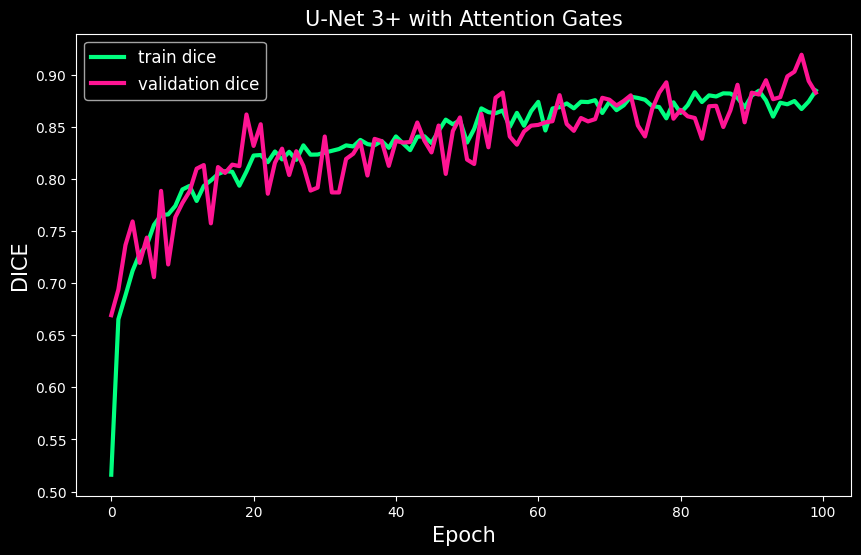

In [39]:
plot_model_history("U-Net 3+ with Attention Gates", aun_th_prev, aun_vh_prev, last_num_ep)
# plt.savefig(f'UNet_3p_attn_dice.png', bbox_inches='tight')

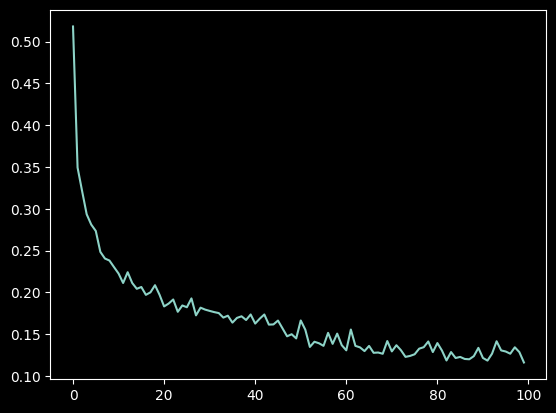

In [40]:
plt.plot(range(last_num_ep), aun_lh_prev)
plt.savefig(f'UNet_3p_attn_loss.png', bbox_inches='tight')

In [41]:
test_iou = compute_iou(unet3p_attn, test_dataloader, device)
print(f"""U-Net 3+ Attention\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

U-Net 3+ Attention
Mean IoU of the test images - 88.0%


# U-Net 3+

In [42]:
unet3p = UNet3Plus(n_classes=1).to(device)

In [43]:
# PATH = "model_unet_3p.pt"

In [44]:
opt_unet_3p = torch.optim.Adamax(unet3p.parameters(), lr=1e-3)

In [ ]:
# %%time
num_ep = 100
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_3p", unet3p, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p, False, num_ep, device=device)

In [ ]:
plot_model_history("U-Net 3+", aun_th, aun_vh, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(unet3p, test_dataloader)
print(f"""U-Net 3+\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")


# UNet with Attention

In [28]:
attention_unet = AttentionUNet(n_classes=1).to(device)

In [29]:
# PATH = "model_unet_with_attn.pt"

In [30]:
opt_unet_attn = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

In [31]:
# %%time
num_ep = 100
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_attn", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt_unet_attn, False, num_ep, device=device)

total params of UNet_attn model: 34878573
trainable params of UNet_attn model: 34878573
[INFO] Model is initializing... UNet_attn


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.8589410336735921 
Mean DICE on train: 0.32597039194385335 
Mean DICE on validation: 0.5495724485187371


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.5107864101345723 
Mean DICE on train: 0.559341716137215 
Mean DICE on validation: 0.6263767457958537


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.39803397980255956 
Mean DICE on train: 0.6199854377572143 
Mean DICE on validation: 0.6578457986511959


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.3929473891472205 
Mean DICE on train: 0.6134383147965174 
Mean DICE on validation: 0.6895859520213403


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.35400468817888164 
Mean DICE on train: 0.6504362947104333 
Mean DICE on validation: 0.6533667227322876


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.3657141100519743 
Mean DICE on train: 0.6370448878688149 
Mean DICE on validation: 0.70330031763984


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.34066385451035625 
Mean DICE on train: 0.6614731150076244 
Mean DICE on validation: 0.6981006906799887


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.3132873467909984 
Mean DICE on train: 0.6900373386174812 
Mean DICE on validation: 0.7008455980832863


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.30305977146594953 
Mean DICE on train: 0.6984561933443553 
Mean DICE on validation: 0.7314531094294727


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.3066519389931972 
Mean DICE on train: 0.6946072493378088 
Mean DICE on validation: 0.748271339364299


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.31427348844515973 
Mean DICE on train: 0.6871104596112596 
Mean DICE on validation: 0.7532827562170592


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.2975621825227371 
Mean DICE on train: 0.7040695122759997 
Mean DICE on validation: 0.7338239166469996


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.2976351974484248 
Mean DICE on train: 0.7030856782856301 
Mean DICE on validation: 0.7954457470394698


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.2677331692897357 
Mean DICE on train: 0.7333756430741556 
Mean DICE on validation: 0.7607308737376866


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.28122300883898366 
Mean DICE on train: 0.7206144479647142 
Mean DICE on validation: 0.7445745472146579


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.28171995950815004 
Mean DICE on train: 0.7217172376577793 
Mean DICE on validation: 0.7559896043244886


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.26161661954262316 
Mean DICE on train: 0.7397212068703656 
Mean DICE on validation: 0.736750686913091


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.27812839242128223 
Mean DICE on train: 0.7225143271110487 
Mean DICE on validation: 0.7340030219866319


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.2909850953863217 
Mean DICE on train: 0.7121596970390559 
Mean DICE on validation: 0.7825737440926824


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.26549032750802165 
Mean DICE on train: 0.7376181132505777 
Mean DICE on validation: 0.7829015597082022


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.26923435353315794 
Mean DICE on train: 0.733856990918016 
Mean DICE on validation: 0.752147711674419


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.2590734085593468 
Mean DICE on train: 0.7413895688620311 
Mean DICE on validation: 0.777663673059925


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.25582267821599275 
Mean DICE on train: 0.7448708918630594 
Mean DICE on validation: 0.8146819582789186


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.24823220570882162 
Mean DICE on train: 0.7560985468743932 
Mean DICE on validation: 0.7304787810069545


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.26366501301527023 
Mean DICE on train: 0.7397362298089254 
Mean DICE on validation: 0.809927624738988


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.24710985999076795 
Mean DICE on train: 0.7562824879845292 
Mean DICE on validation: 0.7800050510446846


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.2515661447094037 
Mean DICE on train: 0.7516378616187238 
Mean DICE on validation: 0.7484366181657773


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.23742788628889963 
Mean DICE on train: 0.7672726071714899 
Mean DICE on validation: 0.7500658640012243


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.22938035887021285 
Mean DICE on train: 0.7712704722619321 
Mean DICE on validation: 0.8233143314532304


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.23665695637464523 
Mean DICE on train: 0.7681669081221765 
Mean DICE on validation: 0.7480514274147098


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.24163598204270387 
Mean DICE on train: 0.7600938953815859 
Mean DICE on validation: 0.8271814065924646


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.22023341938471183 
Mean DICE on train: 0.7803904303336019 
Mean DICE on validation: 0.7928473363117607


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.2215204615241442 
Mean DICE on train: 0.779160166791069 
Mean DICE on validation: 0.7729708611652535


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.21387019333166954 
Mean DICE on train: 0.7866223110202133 
Mean DICE on validation: 0.7757312944219376


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.22308246676738447 
Mean DICE on train: 0.7785076326258485 
Mean DICE on validation: 0.7764881486095031


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.24841743593032545 
Mean DICE on train: 0.7512372439157126 
Mean DICE on validation: 0.7690185256861715


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.2049924488633107 
Mean DICE on train: 0.7952679620955686 
Mean DICE on validation: 0.7861623652953983


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.2232734155960572 
Mean DICE on train: 0.7835868924970874 
Mean DICE on validation: 0.7642290648850966


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.21269776404668123 
Mean DICE on train: 0.7886704278485472 
Mean DICE on validation: 0.826515946853554


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.2065869722610865 
Mean DICE on train: 0.7950305234468726 
Mean DICE on validation: 0.8049866044863097


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.22996538896591234 
Mean DICE on train: 0.7714157931051028 
Mean DICE on validation: 0.8388083034774866


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.21892801825052652 
Mean DICE on train: 0.7822896627626278 
Mean DICE on validation: 0.8226578688251002


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.21644906413096648 
Mean DICE on train: 0.787449977212398 
Mean DICE on validation: 0.8103508959163668


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.20352566012969384 
Mean DICE on train: 0.7976618671957476 
Mean DICE on validation: 0.8572768747879005


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.20653934452014092 
Mean DICE on train: 0.794731326137113 
Mean DICE on validation: 0.8401365327637691


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.1917845041323931 
Mean DICE on train: 0.8094882135556665 
Mean DICE on validation: 0.8186059447411395


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.19537582324865538 
Mean DICE on train: 0.8053998351129399 
Mean DICE on validation: 0.8293590035930456


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.18775357955541366 
Mean DICE on train: 0.8145357848797781 
Mean DICE on validation: 0.7850717083213404


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.1888654188085825 
Mean DICE on train: 0.8133626762151676 
Mean DICE on validation: 0.8102788560095954


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.19869182182428163 
Mean DICE on train: 0.8016696049748641 
Mean DICE on validation: 0.8366615997462137


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [50]
Mean loss on train: 0.19471231465920424 
Mean DICE on train: 0.8055985249077892 
Mean DICE on validation: 0.8402396479449319


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [51]
Mean loss on train: 0.1933677484973883 
Mean DICE on train: 0.808754902800023 
Mean DICE on validation: 0.8015338681537122


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [52]
Mean loss on train: 0.1870942704188518 
Mean DICE on train: 0.8147571580413981 
Mean DICE on validation: 0.8255117632596369


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [53]
Mean loss on train: 0.19791497003573638 
Mean DICE on train: 0.803079993005796 
Mean DICE on validation: 0.7821298033295838


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [54]
Mean loss on train: 0.17769354772873414 
Mean DICE on train: 0.823203529722531 
Mean DICE on validation: 0.8337193287708353


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [55]
Mean loss on train: 0.2083810628988804 
Mean DICE on train: 0.7913453577412128 
Mean DICE on validation: 0.832905075792662


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [56]
Mean loss on train: 0.19884411837810126 
Mean DICE on train: 0.8011739395949505 
Mean DICE on validation: 0.8045993880774333


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [57]
Mean loss on train: 0.20119651273275033 
Mean DICE on train: 0.7998087443855365 
Mean DICE on validation: 0.8216095511830941


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [58]
Mean loss on train: 0.19800954178357735 
Mean DICE on train: 0.8024744284793773 
Mean DICE on validation: 0.8453894943656246


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [59]
Mean loss on train: 0.19443314637129122 
Mean DICE on train: 0.8070455226257932 
Mean DICE on validation: 0.768817885578872


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [60]
Mean loss on train: 0.21006044879173622 
Mean DICE on train: 0.7893942615902493 
Mean DICE on validation: 0.799974130674081


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [61]
Mean loss on train: 0.18533459745156458 
Mean DICE on train: 0.8153556984389488 
Mean DICE on validation: 0.8278466087862087


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [62]
Mean loss on train: 0.18835891171907768 
Mean DICE on train: 0.8145662218025918 
Mean DICE on validation: 0.86318881185941


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [63]
Mean loss on train: 0.20501380222730148 
Mean DICE on train: 0.7947233878720215 
Mean DICE on validation: 0.8507651474128417


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [64]
Mean loss on train: 0.17620061051387054 
Mean DICE on train: 0.8240145153553404 
Mean DICE on validation: 0.8396993663387261


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [65]
Mean loss on train: 0.18048492666238394 
Mean DICE on train: 0.8202974272372252 
Mean DICE on validation: 0.8231031473764272


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [66]
Mean loss on train: 0.19772060406513703 
Mean DICE on train: 0.804117788483234 
Mean DICE on validation: 0.8547909653527666


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [67]
Mean loss on train: 0.192636377345293 
Mean DICE on train: 0.8075709177766012 
Mean DICE on validation: 0.8422999051793122


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [68]
Mean loss on train: 0.1691166231265435 
Mean DICE on train: 0.8312506810477999 
Mean DICE on validation: 0.8515958700930369


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [69]
Mean loss on train: 0.17906098105968574 
Mean DICE on train: 0.8216102840343874 
Mean DICE on validation: 0.8247208218783135


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [70]
Mean loss on train: 0.1919994856684636 
Mean DICE on train: 0.8084993300511378 
Mean DICE on validation: 0.8178252189759805


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [71]
Mean loss on train: 0.19358820945788652 
Mean DICE on train: 0.806649567070252 
Mean DICE on validation: 0.8341822514759153


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [72]
Mean loss on train: 0.1773373782634735 
Mean DICE on train: 0.8236381676739731 
Mean DICE on validation: 0.8463104310773346


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [73]
Mean loss on train: 0.22169483930636674 
Mean DICE on train: 0.7783418870452433 
Mean DICE on validation: 0.8525102490519896


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [74]
Mean loss on train: 0.1756853841436215 
Mean DICE on train: 0.8247642308238793 
Mean DICE on validation: 0.8631734514362713


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [75]
Mean loss on train: 0.1846196962854801 
Mean DICE on train: 0.8155383521932111 
Mean DICE on validation: 0.8068388541047629


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [76]
Mean loss on train: 0.18097303024469277 
Mean DICE on train: 0.8190793317526291 
Mean DICE on validation: 0.8164693455820731


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [77]
Mean loss on train: 0.17758839176251337 
Mean DICE on train: 0.8226318831080862 
Mean DICE on validation: 0.8202189611173029


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [78]
Mean loss on train: 0.16438990391981909 
Mean DICE on train: 0.8365511502667562 
Mean DICE on validation: 0.8197128384165929


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [79]
Mean loss on train: 0.16911291770445994 
Mean DICE on train: 0.8308999300395283 
Mean DICE on validation: 0.7861926105126847


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [80]
Mean loss on train: 0.1783015762384121 
Mean DICE on train: 0.8223867072258199 
Mean DICE on validation: 0.858054897085992


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [81]
Mean loss on train: 0.1821835526289084 
Mean DICE on train: 0.8175575072635828 
Mean DICE on validation: 0.8237614986235511


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [82]
Mean loss on train: 0.18980727172814882 
Mean DICE on train: 0.8099804824813793 
Mean DICE on validation: 0.8407481109345619


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [83]
Mean loss on train: 0.1750700599872149 
Mean DICE on train: 0.8239875038639818 
Mean DICE on validation: 0.8328861014090874


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [84]
Mean loss on train: 0.17862051859115943 
Mean DICE on train: 0.8215375120590511 
Mean DICE on validation: 0.8528290533888935


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [85]
Mean loss on train: 0.18333212324442008 
Mean DICE on train: 0.8180073665632229 
Mean DICE on validation: 0.8656842341469292


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [86]
Mean loss on train: 0.17195043139732802 
Mean DICE on train: 0.8283631732110053 
Mean DICE on validation: 0.8456308697933721


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [87]
Mean loss on train: 0.16984223975585058 
Mean DICE on train: 0.8305796170402209 
Mean DICE on validation: 0.8642330553785283


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [88]
Mean loss on train: 0.18398704207860506 
Mean DICE on train: 0.8158483258088779 
Mean DICE on validation: 0.8193850917553573


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [89]
Mean loss on train: 0.17754986844001672 
Mean DICE on train: 0.8216907784014998 
Mean DICE on validation: 0.8350511915971988


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [90]
Mean loss on train: 0.17548109953984237 
Mean DICE on train: 0.8247210588328358 
Mean DICE on validation: 0.8495061495044572


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [91]
Mean loss on train: 0.16527040130816972 
Mean DICE on train: 0.8340659079745504 
Mean DICE on validation: 0.8776984169408101


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [92]
Mean loss on train: 0.1708522244141652 
Mean DICE on train: 0.8285467288240125 
Mean DICE on validation: 0.8495988510630218


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [93]
Mean loss on train: 0.1678178356244014 
Mean DICE on train: 0.8312578661870308 
Mean DICE on validation: 0.8395634117581685


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [94]
Mean loss on train: 0.15700673636717674 
Mean DICE on train: 0.8430402856241952 
Mean DICE on validation: 0.8307814616359617


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [95]
Mean loss on train: 0.15515476885514382 
Mean DICE on train: 0.8473833477997172 
Mean DICE on validation: 0.823098422048471


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [96]
Mean loss on train: 0.15116270268574739 
Mean DICE on train: 0.8490927989662049 
Mean DICE on validation: 0.8198320331967791


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [97]
Mean loss on train: 0.16527225917730576 
Mean DICE on train: 0.8357340590614992 
Mean DICE on validation: 0.8257754201652037


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [98]
Mean loss on train: 0.16014429793143883 
Mean DICE on train: 0.8398990936232371 
Mean DICE on validation: 0.8825285834307036


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [99]
Mean loss on train: 0.15789680660535127 
Mean DICE on train: 0.841788296208295 
Mean DICE on validation: 0.8334160091120663


FileNotFoundError: [Errno 2] No such file or directory: 'Attention U-Net/Attention U-Net_dice.png'

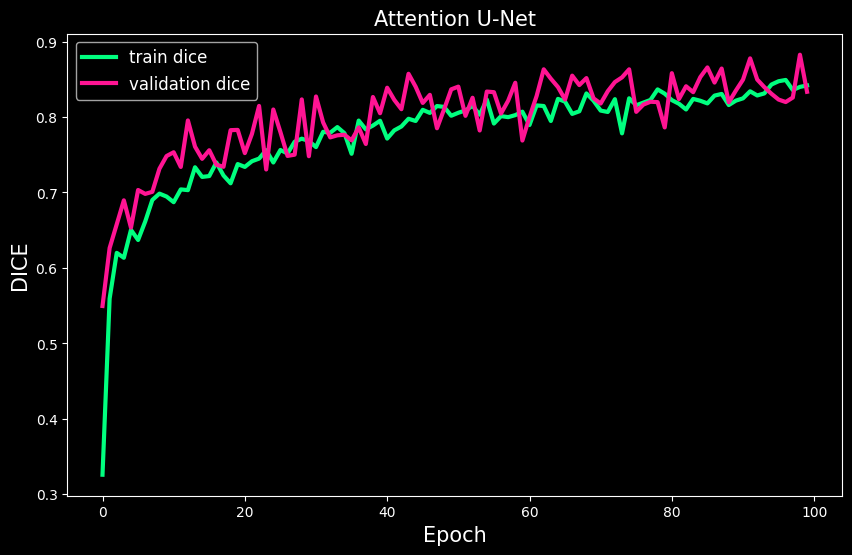

In [32]:
plot_model_history("Attention U-Net", aun_th, aun_vh, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(attention_unet, test_dataloader)
print(f"""Attention U-Net\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

In [ ]:
#============================== EXP : viz pred mask

In [29]:
model_name = "UNet_3p_attn"
model = UNet_3Plus_attn(n_classes=1).to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4)



In [30]:


best_model_chk_point_path = f"/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/v3_pytorch_refactored/checkpoints/UNet_3p_attn/{model_name}_best/best_model.pt"


model, optimizer, last_epoch = load_ckp(best_model_chk_point_path, model, optimizer)


Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 93 number of epochs...


In [31]:
# a = torch.zeros(4, 5, 6)
# a = a.unsqueeze(0)

# a.shape


In [32]:
test_dataset.df.head(10)#[test_dataset.df['diagnosis']==1]

,patient,image_path,mask_path,diagnosis
247,TCGA_FG_5962_20000626,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
3428,TCGA_DU_7010_19860307,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1318,TCGA_DU_8162_19961029,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
2884,TCGA_DU_6404_19850629,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
316,TCGA_DU_A5TY_19970709,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
727,TCGA_DU_7010_19860307,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1718,TCGA_DU_6399_19830416,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1220,TCGA_HT_8113_19930809,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1493,TCGA_HT_8106_19970727,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
804,TCGA_FG_6689_20020326,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0


In [33]:
test_dataset.df[test_dataset.df.diagnosis==1]

,patient,image_path,mask_path,diagnosis
247,TCGA_FG_5962_20000626,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
1493,TCGA_HT_8106_19970727,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
1864,TCGA_DU_8166_19970322,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
3421,TCGA_CS_5397_20010315,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
1373,TCGA_HT_7602_19951103,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
...,...,...,...,...
2252,TCGA_DU_7019_19940908,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
2250,TCGA_DU_8166_19970322,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
280,TCGA_DU_6404_19850629,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
1299,TCGA_CS_6188_20010812,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1


In [61]:
# idx = 1373
# idx = 2252
idx = 280


In [62]:
test_dataset.df.loc[idx]

patient                                   TCGA_DU_6404_19850629
image_path    /Users/srikeshnagoji/Documents/PythonWorkSpace...
mask_path     /Users/srikeshnagoji/Documents/PythonWorkSpace...
diagnosis                                                     1
Name: 280, dtype: object

In [63]:
test_dataset.get_image_and_mask(idx)[1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

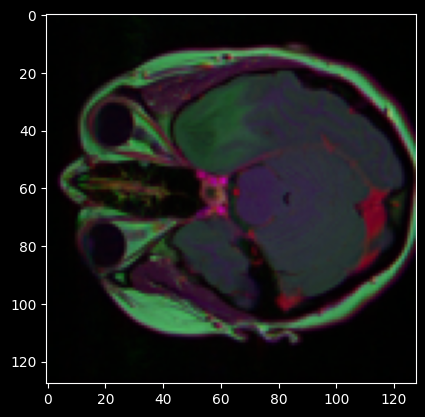

In [64]:
plt.imshow(test_dataset.get_image_and_mask(idx)[0].T)



In [65]:
test_dataset.get_image_and_mask(idx)[1].sum()

tensor(571.)

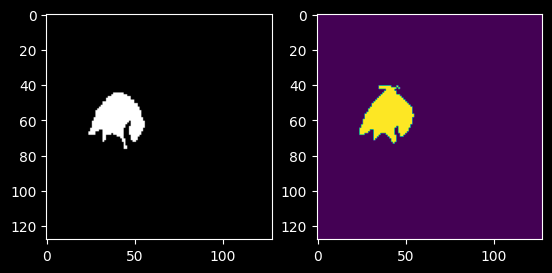

In [66]:
targ, op = viz_pred_output(model,test_dataloader, idx, test_dataset, device)

In [67]:
# target = torch.tensor(test_dataset[idx][1])
# data = torch.tensor(test_dataset[idx][0])
# data = data.to(device).unsqueeze(0)
# target = target.to(device).unsqueeze(0)

# pred = model(data)



f"{np.around(dice_coef_metric(op, targ), 2)*100}%"

'90.0%'

In [ ]:
#==============================